# Reinforcement Learning Model

In [31]:
import os
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from fractions import Fraction

Preprocessing data for later use

In [57]:
# ==== PREPROCESSING ====
def preprocess(image_path, mask_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_rgb = img_rgb.astype(np.float32) / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.float32)

    return img_rgb, mask[..., np.newaxis]

def load_dataset(image_dir, mask_dir):
    image_files = sorted(os.listdir(image_dir))
    X, Y = [], []

    for fname in image_files:
        image_path = os.path.join(image_dir, fname)
        mask_name = fname.replace('.jpg', '_HGE_Seg.jpg')
        mask_path = os.path.join(mask_dir, mask_name)

        if os.path.exists(mask_path):
            img, mask = preprocess(image_path, mask_path)
            X.append(img)
            Y.append(mask)

    return np.array(X), np.array(Y)

## Defining Constants and Useful Functions##

In [ ]:
IMG_SIZE = 128 # resize all of our images to 128 like with the benchmark u-net
NUM_ACTIONS = 9 
HISTORY_SIZE = 10 #
STATE_DIM = 4096 + NUM_ACTIONS * HISTORY_SIZE
MAX_STEPS = 20
EXPERIENCE_SAMPLE_SIZE = 20
MAX_EXPERIENCE_SIZE = 1000
GAMMA = 0.1

In [101]:
def extract_feature(image, history, feature_extractor):
    history_feature = np.zeros(NUM_ACTIONS * HISTORY_SIZE)
    for i in range(HISTORY_SIZE):
        if history[i] != -1:
            history_feature[i * NUM_ACTIONS + history[i]] = 1

    image_resized = cv2.resize(image, (224, 224)).reshape(1, 224, 224, 3)
    image_feature = feature_extractor(image_resized).numpy().flatten()
    return np.array([np.concatenate((image_feature, history_feature))])

def compute_q(feature, model):
    return model.predict(feature, verbose=0).flatten()

def compute_mask(action, box):
    delta_w = 0.1 * (box[2] - box[0])
    delta_h = 0.1 * (box[3] - box[1])
    x1, y1, x2, y2 = box

    if action == 0:  # move right
        x1 += delta_w
        x2 += delta_w
    elif action == 1:  # move left
        x1 -= delta_w
        x2 -= delta_w
    elif action == 2:  # move up
        y1 -= delta_h
        y2 -= delta_h
    elif action == 3:  # move down
        y1 += delta_h
        y2 += delta_h
    elif action == 4:  # zoom in (proportional)
        x1 += delta_w
        x2 -= delta_w
        y1 += delta_h
        y2 -= delta_h
    elif action == 5:  # zoom out (proportional)
        x1 -= delta_w
        x2 += delta_w
        y1 -= delta_h
        y2 += delta_h
    elif action == 6:  # vertical zoom in (squish height)
        y1 += delta_h
        y2 -= delta_h
    elif action == 7:  # horizontal zoom in (squish width)
        x1 += delta_w
        x2 -= delta_w

    # clip box to valid image bounds
    x1 = max(0, min(IMG_SIZE, x1))
    x2 = max(0, min(IMG_SIZE, x2))
    y1 = max(0, min(IMG_SIZE, y1))
    y2 = max(0, min(IMG_SIZE, y2))

    # enforce correct box ordering
    x1, x2 = sorted([x1, x2])
    y1, y2 = sorted([y1, y2])
    return [x1, y1, x2, y2]

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return inter / float(areaA + areaB - inter + 1e-6)

def crop_image(img, box):
    x1, y1, x2, y2 = map(int, box)
    cropped = img[y1:y2, x1:x2]
    return cv2.resize(cropped, (IMG_SIZE, IMG_SIZE)) if cropped.size else np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

## Reward Structures

In [107]:
"""
This is a section on rewards. Currently we define 3 different functions:
binary - 
IoU difference - 
IoU penalty area -

each of the these take in the inputs action, gt, box, and end.
"""

def reward_binary(action, gt, box, end=False, timed_out=False):
    new_iou = compute_iou(compute_mask(action, box), gt)
    old_iou = compute_iou(box, gt)

    if end:
        if timed_out:
            reward = 0
        else:
            reward = 3 if new_iou > 0.1 else -3
    else:
        reward = 1 if new_iou > old_iou else -1
    return reward

def reward_iou_diff(action, gt, box, end=False, timed_out=False):
    new_iou = compute_iou(compute_mask(action, box), gt) 
    old_iou = compute_iou(box, gt)

    if end:
        if timed_out:
            reward = 0
        else:
            reward = 3 if new_iou > 0.6 else -3
    else:
        reward = new_iou - old_iou
    return reward

def reward_iou_area_penalty(action, gt, box, end=False, timed_out=False):
    new_box = compute_mask(action, box)
    new_iou = compute_iou(new_box, gt)
    area = (new_box[2] - new_box[0]) * (new_box[3] - new_box[1])
    norm_area = area / (IMG_SIZE * IMG_SIZE)

    if end:
        if timed_out:
            reward = 0
        else:
            reward = 3 if new_iou > 0.6 else -3
    else:
        reward = new_iou - 0.1 * norm_area
    return reward

def reward_focus_area(action, gt, box, end=False, timed_out=False):
    new_box = compute_mask(action, box)
    iou = compute_iou(new_box, gt)
    
    # Dimensions of current box
    box_w = new_box[2] - new_box[0]
    box_h = new_box[3] - new_box[1]
    full_area = IMG_SIZE * IMG_SIZE
    
    # Prevent division by zero or nonsense
    if box_w <= 0 or box_h <= 0:
        return -1
        
    box_area = box_w * box_h
    
    # If box covers entire image (initial state), give 0 reward
    if box_area >= full_area * 0.99:  # Added small tolerance for floating point
        return 0.0
    
    # How many times this box could fit in the full image (using float division)
    fit_multiplier = full_area / box_area
    
    reward = iou * fit_multiplier
    
    if end:
        if timed_out:
            return 0
        else:
            return 3 if iou > 0.6 else -3
            
    return reward

In [103]:
# ==== MODEL + AGENT ====
def create_q_model():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(STATE_DIM,)),
        Dense(512, activation='relu'),
        Dense(NUM_ACTIONS)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

class QAgent:
    def __init__(self, model, gamma=GAMMA, epsilon=1.0):
        self.model = model
        self.gamma = gamma
        self.epsilon = epsilon
        self.experience = []

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, NUM_ACTIONS - 1)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def remember(self, transition):
        self.experience.append(transition)
        if len(self.experience) > MAX_EXPERIENCE_SIZE:
            self.experience = self.experience[-MAX_EXPERIENCE_SIZE:]

    def train(self):
        if len(self.experience) < EXPERIENCE_SAMPLE_SIZE:
            return
        batch = random.sample(self.experience, EXPERIENCE_SAMPLE_SIZE)
        x_batch, y_batch = [], []
        for s, a, r, s2, done in batch:
            q_values = self.model.predict(s, verbose=0)[0]
            if done:
                q_values[a] = r
            else:
                q_values[a] = r + self.gamma * np.max(self.model.predict(s2, verbose=0)[0])
            x_batch.append(s[0])
            y_batch.append(q_values)
        self.model.train_on_batch(np.array(x_batch), np.array(y_batch))

In [109]:
def train_dqn(X_train, Y_train, vgg16_model, reward_fn, epochs=10, epsilon=1.0):
    feature_extractor = tf.keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.layers[20].output)
    model = create_q_model()
    agent = QAgent(model, epsilon=epsilon)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for i in range(len(X_train)):
            img, mask = X_train[i], Y_train[i]
            ys, xs = np.where(mask.squeeze() > 0)
            if len(xs) == 0 or len(ys) == 0:
                continue

            gt_box = [np.min(xs), np.min(ys), np.max(xs), np.max(ys)]
            history = [-1] * HISTORY_SIZE
            current_box = [0, 0, IMG_SIZE, IMG_SIZE]
            state = extract_feature(img, history, feature_extractor)
            done, step = False, 0

            while not done:
                action = agent.select_action(state)
                next_box = current_box if action == 8 else compute_mask(action, current_box)
                end = action == 8 or step >= MAX_STEPS
                timed_out = step >= MAX_STEPS and action != 8
                reward = reward_fn(action, gt_box, current_box, end=end, timed_out=timed_out)

                print(f"  Image {i}, Step {step}, Action {action}, Reward {reward:.4f}")


                history = history[1:] + [action]
                next_crop = crop_image(img, next_box)
                next_state = extract_feature(next_crop, history, feature_extractor)

                agent.remember((state, action, reward, next_state, end))
                agent.train()

                state = next_state
                current_box = next_box
                step += 1
                done = end

        # Smooth epsilon decay: shrink a bit every epoch, down to a floor
        agent.epsilon = max(agent.epsilon * 0.95, 0.05)

    return agent.model

In [126]:
# ==== EVALUATION ====
def evaluate_model(model, X_test, Y_test, vgg16_model):
    feature_extractor = tf.keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.layers[20].output)
    ious = []
    for i in range(len(X_test)):
        img, mask = X_test[i], Y_test[i]
        ys, xs = np.where(mask.squeeze() > 0)
        if len(xs) == 0 or len(ys) == 0:
            continue
        gt_box = [np.min(xs), np.min(ys), np.max(xs), np.max(ys)]
        history = [-1] * HISTORY_SIZE
        current_box = [0, 0, IMG_SIZE, IMG_SIZE]
        state = extract_feature(img, history, feature_extractor)
        done, step = False, 0

        while not done:
            action = np.argmax(model.predict(state, verbose=0)[0])
            next_box = current_box if action == 8 else compute_mask(action, current_box)
            done = action == 8 or step >= MAX_STEPS
            history = history[1:] + [action]
            next_crop = crop_image(img, next_box)
            state = extract_feature(next_crop, history, feature_extractor)
            current_box = next_box
            step += 1

        iou = compute_iou(current_box, gt_box)
        ious.append(iou)
        print(f"Image {i}, Final IoU: {iou:.4f}")
        print(model.predict(state, verbose=0)[0])


    avg_iou = np.mean(ious)
    print(f"\nAverage IoU on test set: {avg_iou:.4f}")

Similar code to before evaluating binary overlap or not (i.e. we get a reward for having overlap with the ground truth).

In [67]:
def binary_overlap_score(model, image_dir, mask_dir, img_size=128):
    image_files = sorted(os.listdir(image_dir))
    total = 0
    correct = 0

    for fname in image_files:
        img_path = os.path.join(image_dir, fname)
        mask_name = fname.replace('.jpg', '_HGE_Seg.jpg')
        mask_path = os.path.join(mask_dir, mask_name)

        if not os.path.exists(mask_path):
            continue  # skip unmatched files

        # Preprocess input and ground truth
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size))
        mask_bin = (mask > 127).astype(np.uint8)

        # Predict
        pred = model.predict(np.expand_dims(img_rgb, axis=0))[0].squeeze().round().astype(np.uint8)

        # Check if there's any overlap
        overlap = np.logical_and(pred, mask_bin).any()

        total += 1
        if overlap:
            correct += 1

    print(f"Binary overlap score: {correct}/{total}")
    return f"{correct}/{total}", Fraction(correct, total)

In [113]:
train_img_dir = 'mini_dataset/train/images'
train_mask_dir = 'mini_dataset/train/masks'
test_img_dir = 'mini_dataset/test/images'
test_mask_dir = 'mini_dataset/test/masks'

X_train, Y_train = load_dataset(train_img_dir, train_mask_dir)
X_test, Y_test = load_dataset(test_img_dir, test_mask_dir)

vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
model = train_dqn(X_train[:6], Y_train[:6], vgg16, reward_fn = reward_binary, epochs=10, epsilon=1.0)
model.save("dqn_mini_model_binary.keras")

Epoch 1/10
  Image 0, Step 0, Action 8, Reward -3.0000
  Image 1, Step 0, Action 3, Reward 1.0000
  Image 1, Step 1, Action 7, Reward 1.0000
  Image 1, Step 2, Action 0, Reward 1.0000
  Image 1, Step 3, Action 3, Reward 1.0000
  Image 1, Step 4, Action 1, Reward -1.0000
  Image 1, Step 5, Action 8, Reward -3.0000
  Image 2, Step 0, Action 1, Reward 1.0000
  Image 2, Step 1, Action 3, Reward 1.0000
  Image 2, Step 2, Action 8, Reward -3.0000
  Image 3, Step 0, Action 1, Reward 1.0000
  Image 3, Step 1, Action 7, Reward 1.0000
  Image 3, Step 2, Action 6, Reward 1.0000
  Image 3, Step 3, Action 0, Reward -1.0000
  Image 3, Step 4, Action 3, Reward -1.0000
  Image 3, Step 5, Action 3, Reward 1.0000
  Image 3, Step 6, Action 8, Reward -3.0000
  Image 4, Step 0, Action 1, Reward 1.0000
  Image 4, Step 1, Action 0, Reward -1.0000
  Image 4, Step 2, Action 8, Reward -3.0000
  Image 5, Step 0, Action 0, Reward 1.0000
  Image 5, Step 1, Action 6, Reward 1.0000
  Image 5, Step 2, Action 6, Rewar

In [125]:
print(model.predict(state, verbose=0)[0])

NameError: name 'state' is not defined

In [127]:
evaluate_model(model, X_test, Y_test, vgg16)
# binary_overlap_evaluation(model, X_test, Y_test, vgg16)

Image 0, Final IoU: 0.0000
[ 0.36249793  0.48976567  0.62754595  0.6719956   0.71341693 -0.5235986
  0.9545381   0.90082455 -2.367471  ]
Image 1, Final IoU: 0.0000
[ 0.35434392  0.47016868  0.6005905   0.646357    0.690614   -0.5097888
  0.9254699   0.87262756 -2.2916024 ]
Image 2, Final IoU: 0.0030
[ 0.3537324   0.488745    0.6267084   0.66614074  0.7051574  -0.515282
  0.94378626  0.89064443 -2.342234  ]
Image 3, Final IoU: 0.0069
[ 0.40704325  0.48143536  0.60465384  0.68005025  0.7366555  -0.552605
  0.9857575   0.9255948  -2.4299417 ]
Image 4, Final IoU: 0.0024
[ 0.44159675  0.43240836  0.5041109   0.6096183   0.6914215  -0.5422329
  0.9369451   0.86228245 -2.2840092 ]
Image 5, Final IoU: 0.0000
[ 0.35963696  0.5200086   0.6722867   0.70764256  0.73654836 -0.5313267
  0.98359066  0.92673725 -2.4477475 ]
Image 6, Final IoU: 0.0000
[ 0.44089785  0.44697157  0.53823256  0.64396447  0.7159074  -0.55433065
  0.96586543  0.8933341  -2.3603292 ]
Image 7, Final IoU: 0.0000
[ 0.37756985  0

KeyboardInterrupt: 

In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_agent_prediction(model, vgg16_model, image_dir, mask_dir, img_size=128):
    # Select a random image
    image_files = sorted(os.listdir(image_dir))
    sample_file = random.choice(image_files)

    img_path = os.path.join(image_dir, sample_file)
    mask_path = os.path.join(mask_dir, sample_file.replace('.jpg', '_HGE_Seg.jpg'))

    if not os.path.exists(mask_path):
        print(f"No mask found for {sample_file}. Skipping.")
        return

    # Preprocess image
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img_gray, (img_size, img_size))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0

    # Preprocess mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_resized = cv2.resize(mask, (img_size, img_size))
    mask_bin = (mask_resized > 127).astype(np.uint8)

    # VGG16 feature extractor
    feature_extractor = tf.keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.layers[20].output)

    def extract_feature(image, history):
        history_feature = np.zeros(NUM_ACTIONS * HISTORY_SIZE)
        for i in range(HISTORY_SIZE):
            if history[i] != -1:
                history_feature[i * NUM_ACTIONS + history[i]] = 1
        image_input = cv2.resize(image, (224, 224)).reshape(1, 224, 224, 3)
        image_feature = feature_extractor(image_input).numpy().flatten()
        return np.array([np.concatenate((image_feature, history_feature))])

    # Run agent
    history = [-1] * HISTORY_SIZE
    current_box = [0, 0, img_size, img_size]
    trajectory = [current_box.copy()]
    state = extract_feature(img_rgb, history)
    done, step = False, 0

    while not done:
        action = np.argmax(model.predict(state, verbose=0)[0])
        next_box = current_box if action == 8 else compute_mask(action, current_box)
        done = action == 8 or step >= MAX_STEPS
        history = history[1:] + [action]
        next_crop = crop_image(img_rgb, next_box)
        state = extract_feature(next_crop, history)
        current_box = next_box
        trajectory.append(current_box.copy())
        step += 1

    # Plot results
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    axs[0].imshow(img_rgb)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Ground truth overlay
    overlay = img_rgb.copy()
    overlay[mask_bin == 1] = [1.0, 0.0, 0.0]
    axs[1].imshow(overlay)
    axs[1].set_title('Ground Truth Mask Overlay')
    axs[1].axis('off')

    # Trajectory plot
    axs[2].imshow(img_rgb)
    for i, box in enumerate(trajectory[:-1]):
        x1, y1, x2, y2 = map(int, box)
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=1, edgecolor='blue', facecolor='none', alpha=0.3)
        axs[2].add_patch(rect)
    # Final predicted box in green
    x1, y1, x2, y2 = map(int, trajectory[-1])
    axs[2].add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       linewidth=2, edgecolor='lime', facecolor='none', linestyle='--'))
    axs[2].set_title('RL Trajectory (Blue) + Final Box (Green)')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


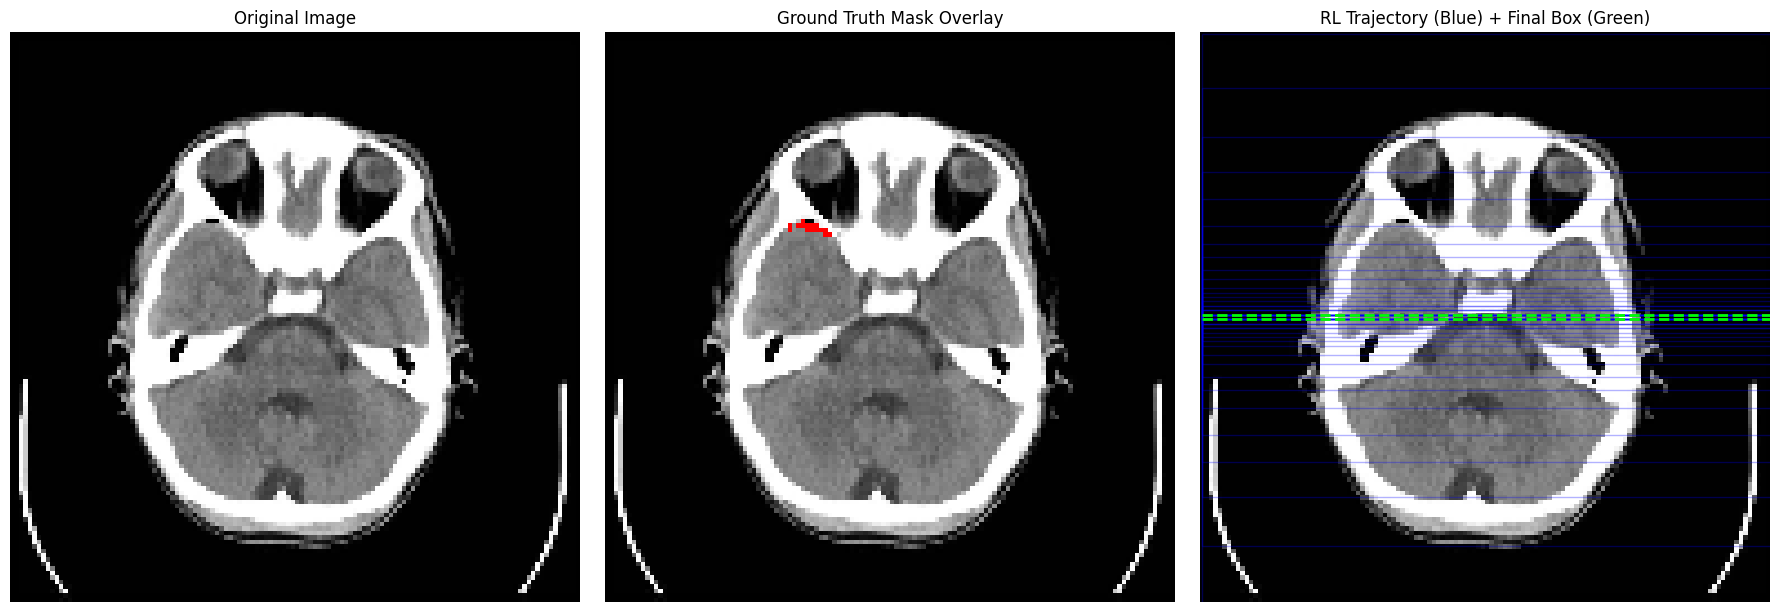

In [128]:
visualize_agent_prediction(model, vgg16, 'mini_dataset/train/images', 'mini_dataset/train/masks')


In [ ]:
X, Y = load_dataset('hemorrhage_CT/images', 'hemorrhage_CT/masks')
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
trained_model = train_dqn(X_train, Y_train, vgg16, epochs=10, epsilon=1.0)
trained_model.save("dqn_hemorrhage_model.h5")

In [81]:
def full_image_iou_score(image_dir, mask_dir, img_size=128):
    image_files = sorted(os.listdir(image_dir))
    sample_file = random.choice(image_files)

    # Paths
    img_path = os.path.join(image_dir, sample_file)
    mask_path = os.path.join(mask_dir, sample_file.replace('.jpg', '_HGE_Seg.jpg'))

    if not os.path.exists(mask_path):
        print(f"Mask not found for {sample_file}. Skipping.")
        return

    # Load and preprocess
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (img_size, img_size))
    mask_bin = (mask > 127).astype(np.uint8)

    ys, xs = np.where(mask_bin > 0)
    if len(xs) == 0 or len(ys) == 0:
        print(f"No tumor in mask for {sample_file}.")
        return

    # Define ground truth box
    gt_box = [np.min(xs), np.min(ys), np.max(xs), np.max(ys)]

    # Define prediction as full image
    pred_box = [0, 0, img_size, img_size]

    # Compute IoU
    iou = compute_iou(pred_box, gt_box)
    print(f"Sample: {sample_file}")
    print(f"Ground Truth Box: {gt_box}")
    print(f"Predicted Full Image Box: {pred_box}")
    print(f"IoU: {iou:.4f}")
    return iou

full_image_iou_score('hemorrhage_CT/images', 'hemorrhage_CT/masks')

Sample: 070_13.jpg
Ground Truth Box: [75, 19, 100, 45]
Predicted Full Image Box: [0, 0, 128, 128]
IoU: 0.0397


0.03967285156007856

In [84]:
vals = []
for _ in range(20):
    vals.append(full_image_iou_score('hemorrhage_CT/images', 'hemorrhage_CT/masks'))
print("average overall: ", np.mean(vals))

Sample: 087_17.jpg
Ground Truth Box: [95, 58, 102, 87]
Predicted Full Image Box: [0, 0, 128, 128]
IoU: 0.0124
Sample: 066_13.jpg
Ground Truth Box: [90, 43, 94, 60]
Predicted Full Image Box: [0, 0, 128, 128]
IoU: 0.0042
Sample: 091_15.jpg
Ground Truth Box: [65, 100, 70, 103]
Predicted Full Image Box: [0, 0, 128, 128]
IoU: 0.0009
Sample: 071_12.jpg
Ground Truth Box: [91, 46, 106, 70]
Predicted Full Image Box: [0, 0, 128, 128]
IoU: 0.0220
Sample: 051_25.jpg
Ground Truth Box: [29, 35, 39, 75]
Predicted Full Image Box: [0, 0, 128, 128]
IoU: 0.0244
Sample: 080_13.jpg
Ground Truth Box: [74, 55, 77, 72]
Predicted Full Image Box: [0, 0, 128, 128]
IoU: 0.0031
Sample: 083_20.jpg
Ground Truth Box: [99, 55, 102, 81]
Predicted Full Image Box: [0, 0, 128, 128]
IoU: 0.0048
Sample: 053_27.jpg
Ground Truth Box: [79, 31, 98, 51]
Predicted Full Image Box: [0, 0, 128, 128]
IoU: 0.0232
Sample: 078_20.jpg
Ground Truth Box: [23, 50, 25, 59]
Predicted Full Image Box: [0, 0, 128, 128]
IoU: 0.0011
Sample: 071_18

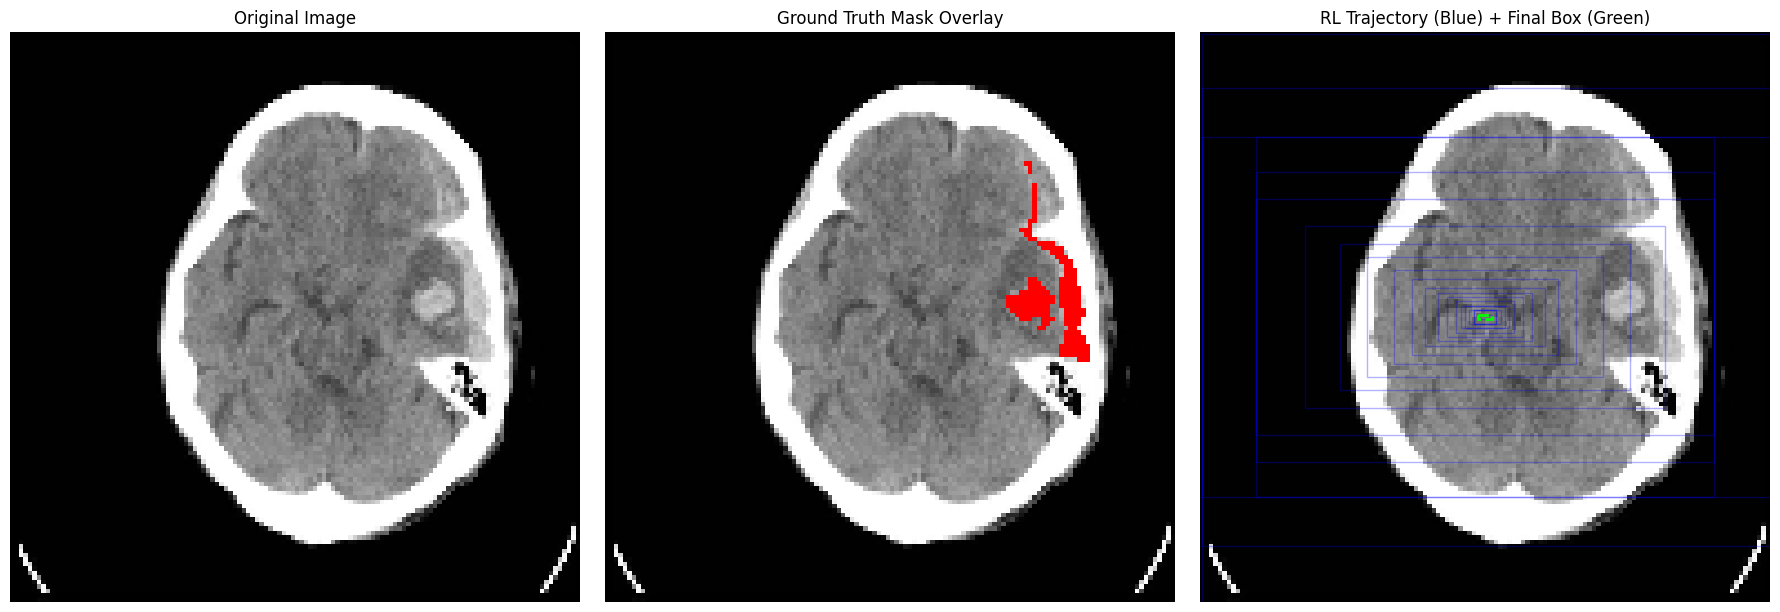

In [96]:
# model_binary = tf.keras.models.load_model('dqn_mini_model.keras')
visualize_agent_prediction(model_binary, vgg16, 'mini_dataset/train/images', 'mini_dataset/train/masks')

In [98]:
def visualize_pre_cnn_input(image_path, mask_path):
    # --- Load original image and mask ---
    original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if original is None or mask is None:
        print("Missing file.")
        return

    # Resize for CNN
    resized_image = cv2.resize(original, (224, 224))
    resized_mask = cv2.resize(mask, (224, 224))
    
    # Normalize + convert to RGB for consistency
    img_rgb = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0
    mask_bin = (mask > 127).astype(np.uint8)
    resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0
    resized_mask_bin = (resized_mask > 127).astype(np.uint8)

    # Create overlays
    overlay_original = img_rgb.copy()
    overlay_original[mask_bin == 1] = [1.0, 0.0, 0.0]  # red

    overlay_resized = resized_rgb.copy()
    overlay_resized[resized_mask_bin == 1] = [1.0, 0.0, 0.0]  # red

    # Plotting
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(overlay_original)
    axs[1].set_title('Original + Mask Overlay')
    axs[2].imshow(resized_image, cmap='gray')
    axs[2].set_title('Resized for CNN (224×224)')
    axs[3].imshow(overlay_resized)
    axs[3].set_title('Resized + Mask Overlay')

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

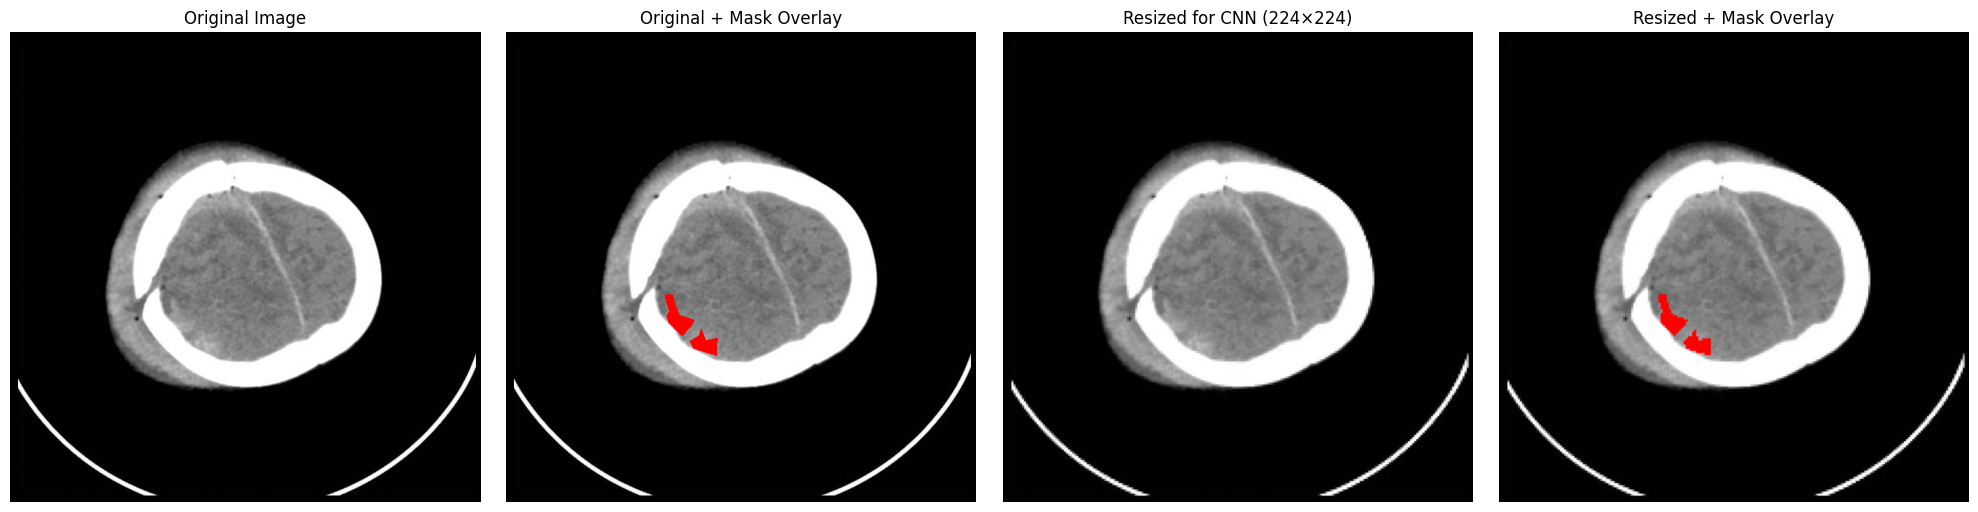

In [100]:
image_path = 'mini_dataset/test/images/051_30.jpg'
mask_path = 'mini_dataset/test/masks/051_30_HGE_Seg.jpg'
visualize_pre_cnn_input(image_path, mask_path)